In [2]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [4]:
# tf.debugging.set_log_device_placement(True)

In [5]:
tf.__version__

'2.1.0'

In [6]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9231612178220754650
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15592824727579655294
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5987571675188096952
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7632217527108202227
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
]


In [7]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [8]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,0.5_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [9]:
projections = data['Projections']
projections.shape

(5000, 275, 275)

In [10]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

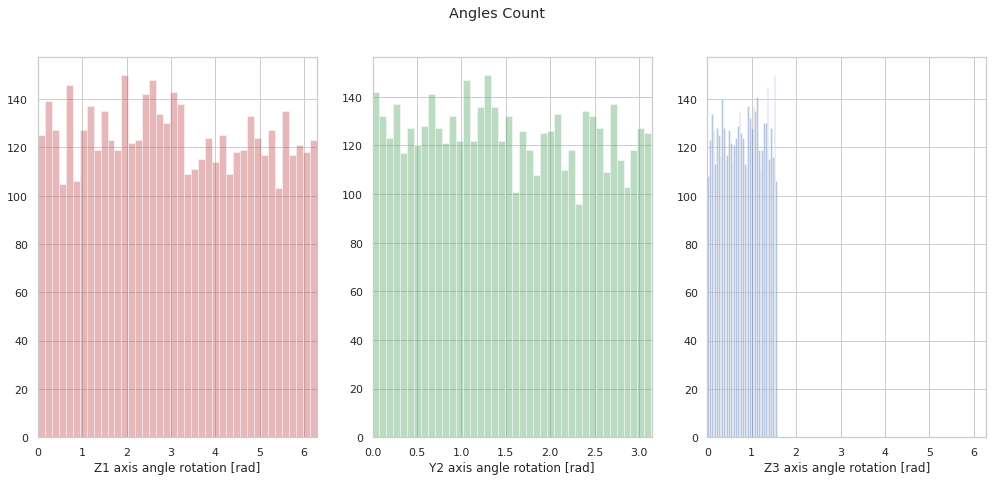

In [11]:
plot_angles_count(angles_true)

In [12]:
from skimage.transform import resize

def rescale_image(image):
    c = image.shape[-1]/117
    image_resized = resize(image, (image.shape[0] // c, image.shape[1] // c), anti_aliasing=True)
    return image_resized

In [13]:
projections_new = []
for p in projections:
    projections_new.append(rescale_image(p))
projections_new = np.array(projections_new)
projections_new.shape

(5000, 116, 116)

In [14]:
from cryoem.distance_estimation import global_standardization

In [15]:
X, y = np.array(projections_new, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [16]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 2.955 | Std: 7.368
Min:  0.000 | Max: 74.906
Mean: 0.000 | Std: 1.000
Min:  -0.401 | Max: 9.766


In [17]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [18]:
X.shape

(5000, 116, 116, 1)

---

## Angle Recovery: Estimated Distance FULL

In [19]:
model_filename = f"training/noisy_var0_{PROTEIN}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [20]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [21]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [22]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

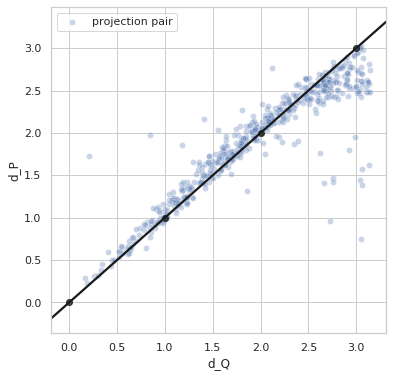

<Figure size 432x288 with 0 Axes>

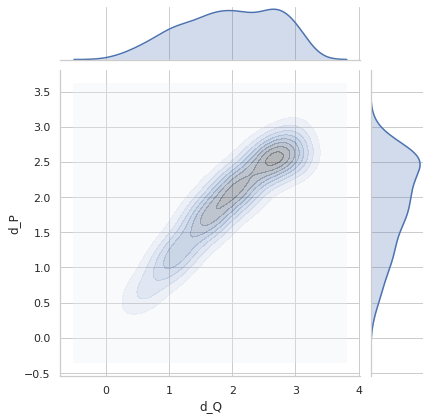

Variance = 0.3040537322580592
Min. angle recovery loss possible = 0.09226810828736014


In [23]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [23]:
from cryoem.angle_recovery import train_angle_recovery

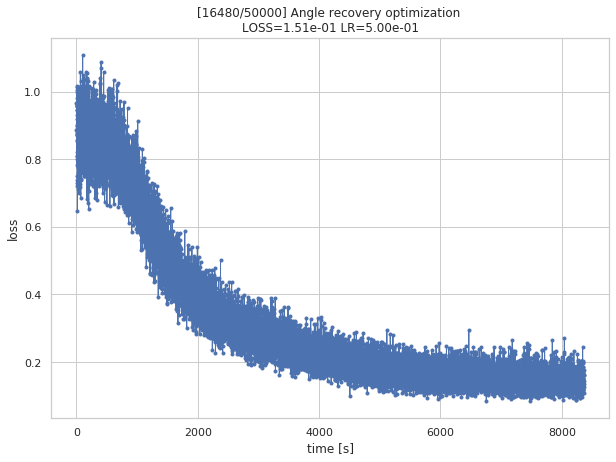

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X, 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             high_ang_const=[2.0, 1.0, 0.5],
                             file_name="/mnt/scratch/students/angle_recovery_5a1a_limited3.14_estimated_50k")

In [24]:
from cryoem.conversions import quaternion2euler

In [25]:
data = np.load("/mnt/scratch/students/angle_recovery_5a1a_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

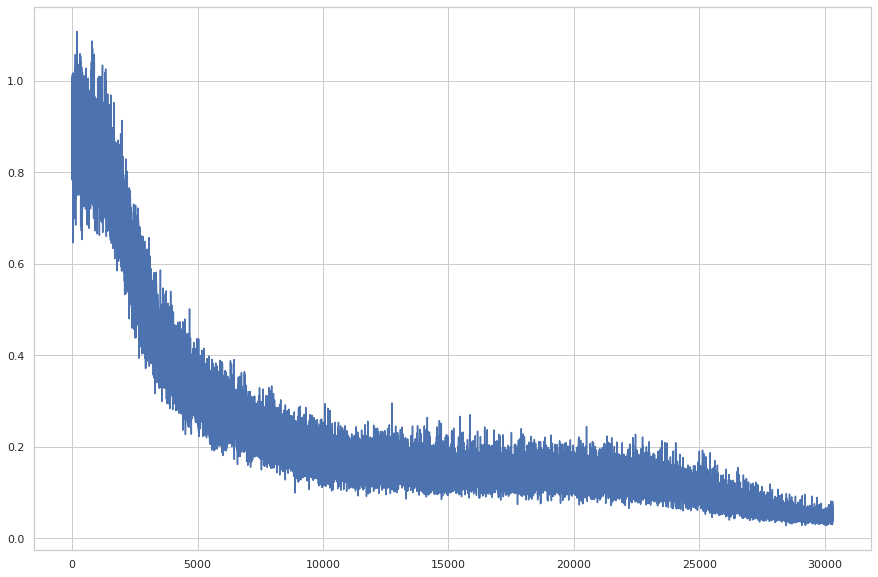

In [26]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[:30330])#[losses>1e-6])
plt.show()

In [27]:
np.mean(losses[:30330][-10:])

0.045185269575119966

In [28]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save("data/5j0n/angles_predicted_5a1a_limited3.14_estimated_50k", angles_predicted)

### Angle Alignment

In [29]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

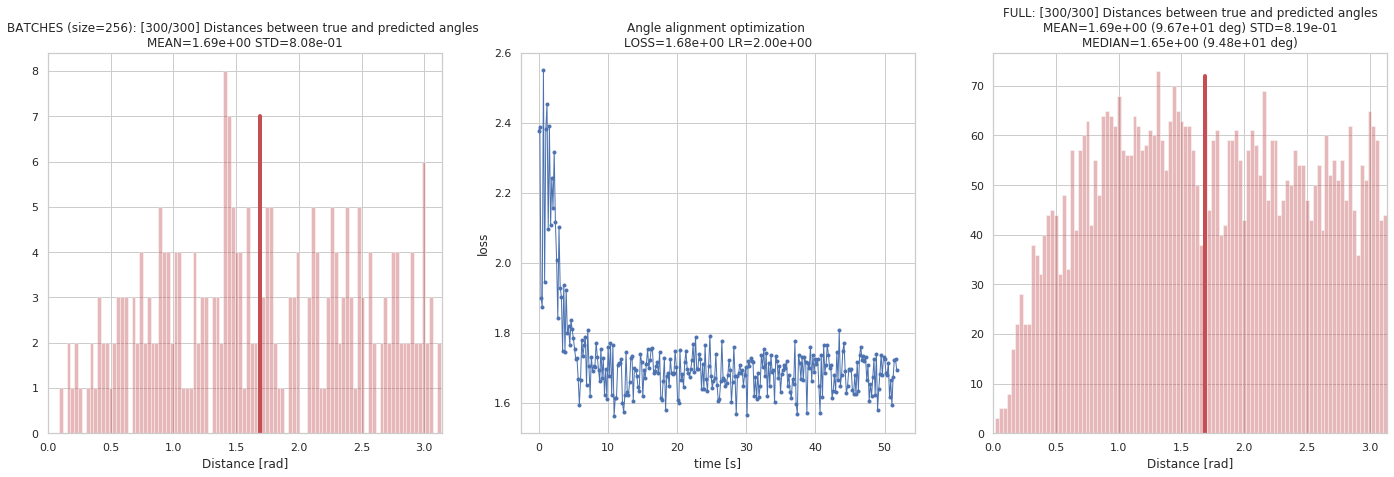

step 30/300 (7s): loss = 2.05e+00
step 60/300 (12s): loss = 1.71e+00
step 90/300 (17s): loss = 1.67e+00
step 120/300 (22s): loss = 1.69e+00
step 150/300 (27s): loss = 1.70e+00
step 180/300 (32s): loss = 1.67e+00
step 210/300 (38s): loss = 1.68e+00
step 240/300 (43s): loss = 1.68e+00
step 270/300 (48s): loss = 1.69e+00
step 300/300 (55s): loss = 1.68e+00



In [30]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

In [31]:
losses[-1], m, a_R

(0.18706397562242297,
 [1.0, 1.0, 1.0, -1.0],
 [<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
  array([-27.80868608,  -0.07020486, -15.19441286, -15.56271133,
           6.2689729 ,  -2.27973311])>])

In [32]:
m = m
trajectory_first = trajectory[0]
loss_first = losses[0]
trajectory_last = trajectory[-1]
loss_last = losses[-1]

In [33]:
m, trajectory_first, loss_first, trajectory_last, loss_last

([1.0, 1.0, 1.0, -1.0],
 array([6.22477741, 6.25162333, 0.51550065, 3.07337472, 1.7579969 ,
        3.31111561]),
 1.70260164305992,
 array([-27.80868608,  -0.07020486, -15.19441286, -15.56271133,
          6.2689729 ,  -2.27973311]),
 0.18706397562242297)

In [34]:
np.save("/mnt/scratch/students/5a1a_angles_predicted.npy", angles_predicted)
np.save("/mnt/scratch/students/5a1a_angles_true.npy", angles_true)
np.save("/mnt/scratch/students/5a1a_projections.npy", projections)

In [35]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

np.save("/mnt/scratch/students/5a1a_angles_predicted_rotated.npy", angles_predicted_rotated)

In [ ]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [ ]:
plot_iterations_polar_plot(collect_data, angles_true, interval=200, connections=False, selected=None)

In [ ]:
ipv.screenshot()

In [ ]:
plot_iterations_rotvec(collect_data, angles_true, interval=200)